Matplotlib is building the font cache; this may take a moment.


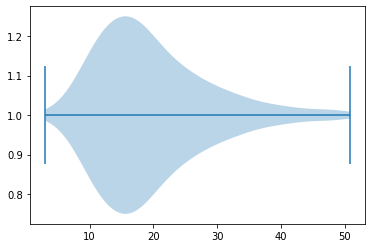

In [3]:
import matplotlib.pyplot as plt
import pandas as pd

# Initialize Figure and Axes object
fig, ax = plt.subplots()

# Load in data
tips = pd.read_csv("https://raw.githubusercontent.com/mwaskom/seaborn-data/master/tips.csv")

# Create violinplot
ax.violinplot(tips["total_bill"], vert=False)

# Show the plot
plt.show()

   total  speeding  alcohol  not_distracted  no_previous  ins_premium  \
0   18.8     7.332    5.640          18.048       15.040       784.55   
1   18.1     7.421    4.525          16.290       17.014      1053.48   
2   18.6     6.510    5.208          15.624       17.856       899.47   
3   22.4     4.032    5.824          21.056       21.280       827.34   
4   12.0     4.200    3.360          10.920       10.680       878.41   

   ins_losses abbrev  
0      145.08     AL  
1      133.93     AK  
2      110.35     AZ  
3      142.39     AR  
4      165.63     CA  


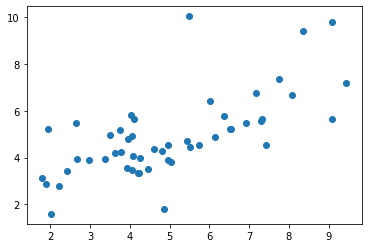

In [5]:
import seaborn as sns
df = sns.load_dataset('car_crashes')
print(df.head())

from matplotlib import pyplot as plt
import seaborn as sns
plt.scatter(df.speeding,df.alcohol)
plt.show()

array([[<AxesSubplot:title={'center':'paper_id'}>,
        <AxesSubplot:title={'center':'citation_count'}>,
        <AxesSubplot:title={'center':'estimated_citation'}>],
       [<AxesSubplot:title={'center':'years_old'}>,
        <AxesSubplot:title={'center':'reference_count'}>,
        <AxesSubplot:title={'center':'num_authors'}>],
       [<AxesSubplot:title={'center':'journal_id'}>,
        <AxesSubplot:title={'center':'multiplier'}>, <AxesSubplot:>]],
      dtype=object)

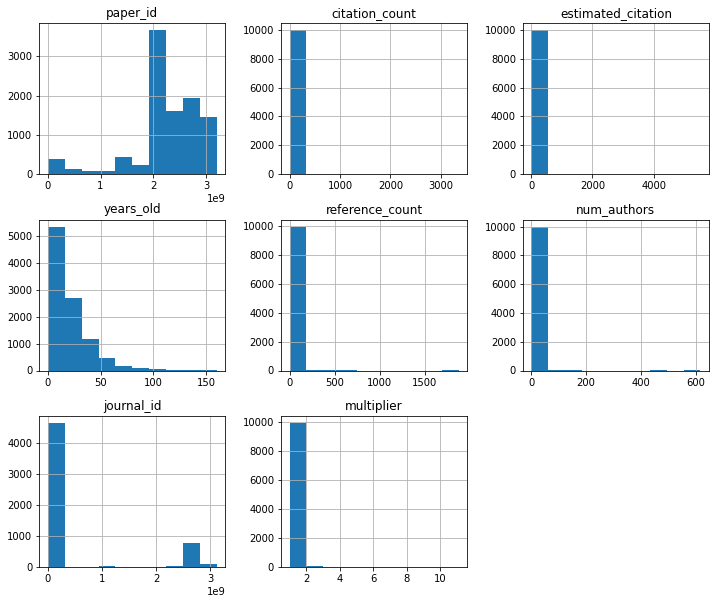

In [21]:
import psycopg2
import os
from urllib.parse import urlparse
    
# pyodbc connection string
# connection_string = "Driver={Amazon Redshift (x64)}; Server=openalex-4.cnw77bm9bpcp.us-east-1.redshift.amazonaws.com; Database=dev; UID=awsuser; PWD=CraftRamen42!; Port=5439"
# conn = pyodbc.connect(connection_string, autocommit=True)

connection_string = urlparse(os.getenv("DATABASE_URL_OPENALEX_REDSHIFT"))
username = connection_string.username
password = connection_string.password
database = connection_string.path[1:]
hostname = connection_string.hostname
port = connection_string.port

conn = psycopg2.connect(
    database = database,
    user = username,
    password = password,
    host = hostname,
    port = port
)

# SQL query to Dremio
sql_query = r""" SELECT * 
    FROM util.temp_data_estimated_citation 
    where citation_count > 0
    order by random() 
    limit 10000"""

df2 = pd.read_sql(sql_query, conn)
df2.hist(figsize=(12,10))

In [20]:
df2


,paper_id,citation_count,estimated_citation,years_old,genre,reference_count,num_authors,journal_id,display_name,publisher,multiplier
0,248282803,0.0,0.0,31.0,None,0.0,1.0,NaN,None,None,0.0
1,1984423179,299.0,299.0,8.0,journal-article,319.0,5.0,205231332.0,Astronomy and Astrophysics,EDP Sciences,1.0
2,1763060701,7.0,7.0,22.0,None,0.0,5.0,48754089.0,Atencion Primaria,Elsevier,1.0
3,3024849057,0.0,0.0,1.0,None,0.0,1.0,NaN,None,None,0.0
4,1575501681,0.0,0.0,28.0,proceedings-article,0.0,5.0,NaN,None,None,0.0
...,...,...,...,...,...,...,...,...,...,...,...
9995,2852021608,0.0,0.0,5.0,None,5.0,3.0,NaN,None,None,0.0
9996,2075033535,9.0,9.0,15.0,journal-article,51.0,1.0,154646843.0,Science and Technology of Advanced Materials,Taylor & Francis,1.0
9997,2930881174,0.0,0.0,11.0,None,0.0,2.0,NaN,None,None,0.0
9998,2120985829,5.0,5.0,15.0,proceedings-article,4.0,3.0,NaN,None,None,1.0
